## Кириллов Д.С. ИУ5-22М

Вариант 7 (нечетный) -> файл v1.h5.



In [224]:
from datetime import datetime
import numpy as np
import pandas as pd
import time
import glob
import h5py
import os
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.client import device_lib
from keras import regularizers
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report # добавил classification_report

from tensorflow import summary as tfsummary

%matplotlib inline
%load_ext tensorboard

tf.random.set_seed(42)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Подготовка

Keras по умолчанию использует Tensorflow под капотом. Хотя можно использовать другие библиотеки. Нужно убедиться, что он знает про сущестование GPU на устройстве. Вывод device_lib.list_local_devices() должен быть что-то типа:
```
[
  name: "/cpu:0"device_type: "CPU",
  name: "/gpu:0"device_type: "GPU"
]
```

**Если не выводит GPU, у вас проблема**

In [225]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1831411123564258378
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16274030592
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12852934822875683272
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [226]:
!nvidia-smi

Mon Apr 15 13:51:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0              35W / 250W |  15896MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [227]:
#!mkdir -p models/lab6
#!mkdir data
#!rm data/v1.h5
#!wget -P data https://raw.githubusercontent.com/iu5git/Deep-learning/main/datasets/lidar/v1.h5

In [228]:
DATA_DIR = "data"
H5_FILE_PATH = os.path.join(DATA_DIR, "v1.h5")
print(os.system("ls -la " + H5_FILE_PATH))

h5f = h5py.File(H5_FILE_PATH,'r') # файл по вашему варианту
X = h5f.get('dataset_X')[:]
Y = h5f.get('dataset_Y').asstr()[:]
h5f.close()

-rw-r--r-- 1 root root 21504848 Apr 15 12:44 data/v1.h5
0


# Константы

In [229]:
NUM_POINTS = 4096 # не трогаем. Это особенность датасета

# BATCH_SIZE = 64 # по умолчанию
BATCH_SIZE = 128
# EPOCHS = 10 # по умолчанию
EPOCHS = 20
# LR = 0.001 # по умолчанию
LR = 5e-3
WD = 1e-5

# От Ишкова:
# - Можно попробовать поварьировать momentum. В Adam momentum обозначается beta_1. Поможет справиться со сткачками точности от итерации к итерации
# - Можно попробовать поварьировать размерность слоя MaxPooling (один из главных слоев в POINTNET)

# Датасет

In [230]:
# Укажите классы по варианту из вашего файла
CLASSES = {
    0:'Рябина', 
    1:'Ель', 
    2:'Сосна', 
    3:'Дуб',
    4:'Береза'
}

Y = np.array([list(CLASSES.values()).index(y) for y in Y])
indexes = []
[indexes.append(y) for y in list(Y) if y not in indexes]
indexes.sort()
CLASS_MAP = {i: CLASSES[k] for (k, i) in (zip(indexes, range(len(indexes))))}

# кол-во классов по вашему варианту
NUM_CLASSES = len(CLASS_MAP)

for (k, i) in (zip(indexes, range(len(indexes)))):
  Y[Y == k] = i

/tmp/ipykernel_35/4080713930.py:9: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  data = {'Кол-во деревьев': list(pd.value_counts(Y).sort_index()),


Кол-во деревьев
Деревья                 
Рябина                35
Ель                  242
Сосна                160

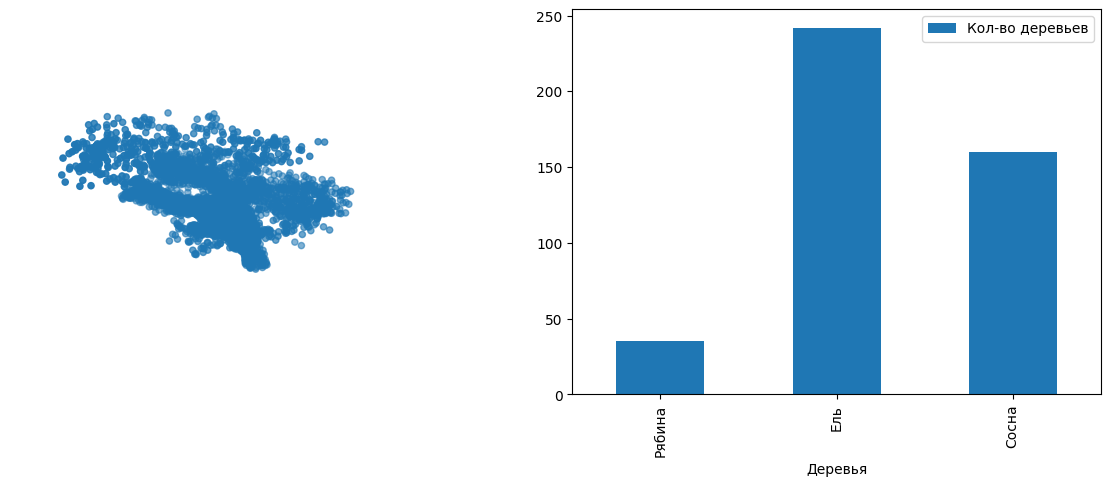

In [231]:
points = X[50]

fig = plt.figure(figsize=(15, 5))
axs = (fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2))

axs[0].scatter(points[:, 0], points[:, 1], points[:, 2])
axs[0].set_axis_off()

data = {'Кол-во деревьев': list(pd.value_counts(Y).sort_index()),
        'Деревья': list(CLASS_MAP.values())}
df = pd.DataFrame(data).set_index('Деревья')

df.plot.bar(ax=axs[1])
df

# Разбиение выборки на тренировочную и тестовую

In [232]:
skf = StratifiedKFold(n_splits=5).split(X, Y)

for train_index, test_index in skf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

In [233]:
X_train.shape

(350, 4096, 3)

In [234]:
X_augment = []
y_augment = []

# В 4 раза увеличиваем выборку
for i in range(2):
    point_select = []
    for x in X_train:
        idx = np.random.choice(X_train.shape[1], size=NUM_POINTS, replace=True)
        point_select.append(x[idx])
    point_select = np.array(point_select)
    # Аугментация - это добавление шума с нормальным распределением с параметрами 0, 0.005 к каждой координате
    point_select = point_select + np.random.normal(0, 0.005, point_select.shape)
    X_augment.append(point_select)
    y_augment.append(y_train)

X_augment = np.array(X_augment)
y_augment = np.array(y_augment)
X_augment = np.reshape(X_augment,(X_augment.shape[0] * X_augment.shape[1], NUM_POINTS, 3))
y_augment = np.reshape(y_augment,(-1))

print('Размеры исходной выборки train/test:', len(X_train), len(y_train), len(X_test), len(y_test))
print('Размеры аугментированной выборки train:', len(X_augment), len(y_augment))
X_augment.shape

Размеры исходной выборки train/test: 350 350 87 87
Размеры аугментированной выборки train: 700 700


(700, 4096, 3)

In [235]:
# добавил вывод размеров
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch

train_dataset = tf.data.Dataset.from_tensor_slices((X_augment, y_augment))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

print('train size:', len(train_dataset), '| test size:',  len(test_dataset))

# свойство len на объектах train_dataset, test_dataset после разбиения на батче будет давать размер дополнительного измерения
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch
train_dataset = train_dataset.shuffle(len(X_augment)).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(X_test)).batch(BATCH_SIZE)

print('train num batches:', len(train_dataset), '| test num batches:',  len(test_dataset), f'(Размер батча {BATCH_SIZE})')

train size: 700 | test size: 87
train num batches: 6 | test num batches: 1 (Размер батча 128)


# Tensorboard

Tensorboard в этой лабе не просят.

Tensorboard Extension не работает в ноутбуках Kaggle

In [236]:
# Общее имя для модели, логов в TensorBoard, архива с логами
MODEL_NAME = datetime.now().strftime("%d.%m-%H:%M:%S")  # даты будут -3 часа, т.к. часовой пояс на сервере Kaggle - UTC +0
os.environ["MODEL_NAME"] = MODEL_NAME # буду использовать для названия zip-архива в unix-команде
MODEL_NAME

'15.04-13:51:02'

In [237]:
train_log_dir = 'logs/tensorboard-lab6/train/' + MODEL_NAME
test_log_dir = 'logs/tensorboard-lab6/test/' + MODEL_NAME
train_summary_writer = tfsummary.create_file_writer(train_log_dir)
test_summary_writer = tfsummary.create_file_writer(test_log_dir)

# Построение модели

Это все взято отсюда https://keras.io/examples/vision/pointnet/

Каждый сверточный и полносвязный слой (не включая конечных слоев) состоит из Convolution / Dense -> Batch Normalization -> ReLU Activation.

In [238]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

PointNet состоит из двух основных компонентов: основная сеть MLP (многослойный перцептрон) и трансформаторная сеть T-net.

In [239]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

Определим общую функцию для построения слоев T-net

In [240]:
def tnet(inputs, num_features):
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [241]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 4096, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_77 (Conv1D)  │ (None, 4096, 32)  │        128 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4096, 32)  │        128 │ conv1d_77[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_119      │ (None, 4096, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_78 (Conv1D)  │ (None, 4096, 64)  │      2,112 │ activation_119[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4096, 64)  │        256 │ conv1d_78[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_120      │ (None, 4096, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_79 (Conv1D)  │ (None, 4096, 512) │     33,280 │ activation_120[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4096, 512) │      2,048 │ conv1d_79[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_121      │ (None, 4096, 512) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_121[0… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_63 (Dense)    │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_63[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_122      │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 128)       │     32,896 │ activation_122[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_64[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_123      │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_65 (Dense)    │ (None, 9)         │      1,161 │ activation_123[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_14          │ (None, 3, 3)      │          0 │ dense_65[0][0]  

 Total params: 748,076 (2.85 MB)

 Trainable params: 741,996 (2.83 MB)

 Non-trainable params: 6,080 (23.75 KB)

# Обучение модели

In [242]:
%%time

# См. https://habr.com/ru/articles/485890/
# Добавил в эту ячейку коллбек для сбора логов

model.compile(
    # Заменил на Adam. SGD багается: loss и val_loss у него nan
    optimizer=keras.optimizers.Adam(learning_rate=LR, weight_decay=WD, ),
    loss="sparse_categorical_crossentropy",
    metrics=[keras.metrics.SparseCategoricalAccuracy()], # Можно еще так metrics=['accuracy'] или так metrics=['acc']
    
    # https://keras.io/api/metrics/accuracy_metrics/
    # metrics=[keras.metrics.Accuracy()], # не подходит для sparse_categorical_crossentropy. Не путать с metrics=['accuracy']
    # metrics=["sparse_categorical_accuracy"], # только для oneHot кодирования и loss="categorical_crossentropy"
)

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=train_log_dir)

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset,
    # запись в tensorboard. Пишутся и test, и train
    callbacks=[tensorboard_callback],
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - loss: 27076.8652 - sparse_categorical_accuracy: 0.4604 - val_loss: 3780561.5000 - val_sparse_categorical_accuracy: 0.4713
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 568ms/step - loss: 14556.8291 - sparse_categorical_accuracy: 0.6267 - val_loss: 51708.5664 - val_sparse_categorical_accuracy: 0.5517
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 568ms/step - loss: 1410.8184 - sparse_categorical_accuracy: 0.6095 - val_loss: 2544.6714 - val_sparse_categorical_accuracy: 0.6092
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 567ms/step - loss: 1122.9011 - sparse_categorical_accuracy: 0.6758 - val_loss: 684.4802 - val_sparse_categorical_accuracy: 0.6667
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 567ms/step - loss: 1021.7233 - sparse_categorical_accuracy: 0.7060 - val_loss: 810.9613 - val_sparse_categorical_accuracy: 0.7126
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 567ms/step - loss: 967.0749 - sparse_categorical_accuracy: 0.7534 - val_loss: 1504.1406 - val_sparse_categori

Скачиваю архив с логами, чтобы посмотреть локально.

На панели справа ЛКМ по "обновить папку kaggle/working/" > листаем до файла .zip > три точки > Download.

In [243]:
!zip -r "logs/tensorboard-logs-$MODEL_NAME.zip" logs/tensorboard-lab6 > /dev/null 2>&1

# Визуализация результатов

15.04-13:51:02
точность = sparse_categorical_accuracy
Максимальная точность train 0.7742857336997986 на 17 эпохе
Максимальная точность test  0.7931034564971924 на 11 эпохе
Текущая точность train 0.7442857027053833 | test  0.7011494040489197


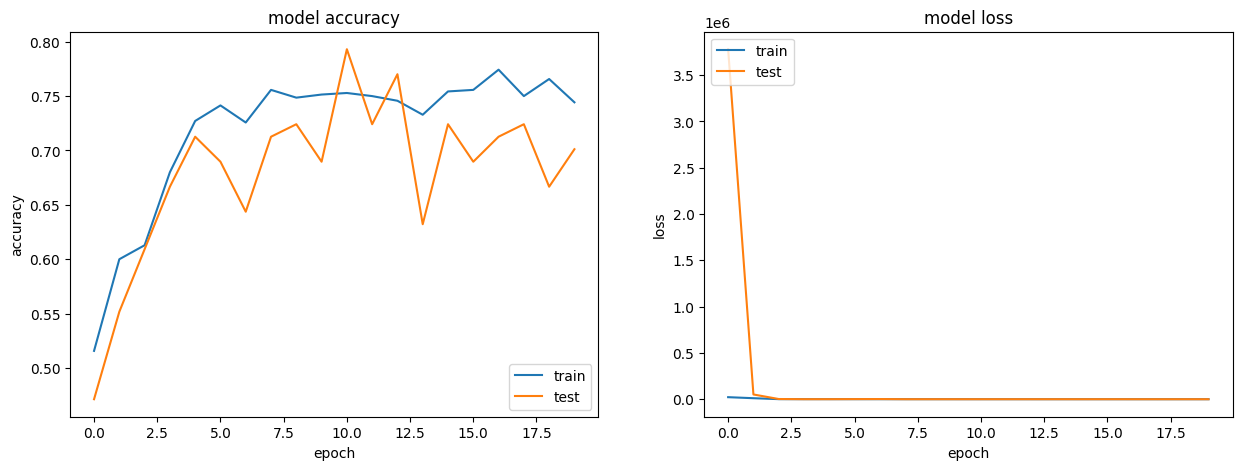

In [244]:
# Объединил 2 графика в 1

print(MODEL_NAME)

fig, axes = plt.subplots(1, 2, figsize=(15,5))

axes[0].plot(history.history['sparse_categorical_accuracy'], label='train')
axes[0].plot(history.history['val_sparse_categorical_accuracy'], label='test')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(loc="lower right")

axes[1].plot(history.history['loss'], label = 'train')
axes[1].plot(history.history['val_loss'], label='test')
axes[1].set_title('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(loc="upper left")

train_current = history.history['sparse_categorical_accuracy'][-1]
train_max_idx = np.argmax(history.history['sparse_categorical_accuracy'])
train_max = history.history['sparse_categorical_accuracy'][train_max_idx]
test_current = history.history['val_sparse_categorical_accuracy'][-1]
test_max_idx = np.argmax(history.history['val_sparse_categorical_accuracy'])
test_max = history.history['val_sparse_categorical_accuracy'][test_max_idx]
print('точность = sparse_categorical_accuracy')
print(f'Максимальная точность train {train_max} на {train_max_idx + 1} эпохе');
print(f'Максимальная точность test  {test_max} на {test_max_idx + 1} эпохе');
print(f'Текущая точность train {train_current} | test  {test_current}');

In [245]:
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('model loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()

In [ ]:
# Это типа деревья. Как столы и стулья здесь https://keras.io/examples/vision/pointnet/ (в самом низу страницы)

# Это просто вывод результата модели на случайно выбранном батче на тестовой выборке.
# Всего (размер тестовой выборки 87) / BATCH_SIZE вариантов этого графика - столько же, сколько батчей.
# В целом, график бесполезный. Вывод всегда разный

# Пояснения про test_dataset.take(1) см. ниже

print(MODEL_NAME)

data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

fig = plt.figure(figsize=(10, 10))
for i in range(8):
    ax = fig.add_subplot(3, 3, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

15.04-13:51:02
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


# Проверка качества модели

In [247]:
# Переписал так, чтобы справа выводилась табличка classification_report

def plot_confusion_matrix(labels, preds, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true=labels, y_pred=preds)
    
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    im1 = axes[0].imshow(cm, interpolation='nearest', cmap=cmap)
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    
    axes[0].set_title(title)
    tick_marks = np.arange(len(classes))
    axes[0].set_xticks(tick_marks, classes, rotation=45)
    axes[0].set_yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        axes[0].text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    axes[0].set_ylabel('True label')
    axes[0].set_xlabel('Predicted label')
    
    print(len(labels), len(preds))
    axes[1].set_axis_off()
    axes[1].text(0.4, 0.5, classification_report(
            labels, preds,
            digits=4, target_names=list(map(str, classes))
        ),
        horizontalalignment='center',
        verticalalignment='center',
        transform=axes[1].transAxes,
        fontsize=20
    )
    # альтернатива
    # axes[1].annotate(classification_report(labels, preds), xy=(0, 0))

In [248]:
# Код Ишкова считает confusion matrix для 1 батча
# Можно сравнить вывод для первого батча из BATCH_SIZE = 64 элементов
# для второго батча - 87 - 64 = 23 элементов
# ниже я считаю то же самое для всего датасета из 87 элементов

# data = test_dataset.take(2)   # data - это Tensorflow.Dataset из одного элемента - первого батча в тестовом датасете
# print("число батчей:", len(data))
# Это способ извлечь иксы и игреки X_test (points), y_test (labels)
# points, labels = list(data)[0] # первый батч
# points, labels = list(data)[1] # второй

# размер этих списков = BATCH_SIZE
# points = points[:, ...]
# labels = labels[:, ...]
# print(len(points))

# preds = model.predict(points)
# preds = tf.math.argmax(preds, -1)

# cm = confusion_matrix(y_true=labels, y_pred=preds)
# plot_confusion_matrix(labels, preds, classes=CLASS_MAP.values(), title='Confusion Matrix')

(87, 4096, 3) (87,)
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step
15.04-13:51:02
Confusion matrix, without normalization
[[ 0  5  2]
 [ 0 41  7]
 [ 0 12 20]]
87 87


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


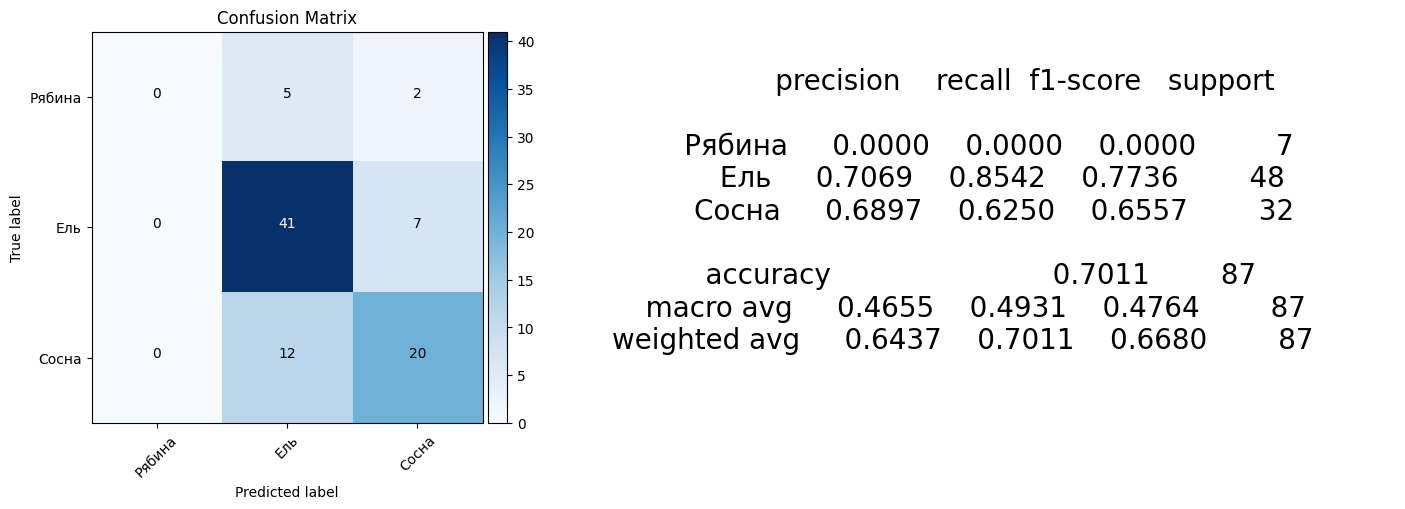

In [249]:
# Вот так можно убрать батчи и получить всю выборку обратно, как она была
# points = np.concatenate([x, y for x, y in test_dataset], axis=0)
# НО!
# Каждое обращение через take или iterator (in test_dataset) возвращает разную выборку
# https://stackoverflow.com/questions/58663198/does-tf-data-dataset-take-return-random-sample
# поэтому надо вытаскивать  и labels таким вот сложным способом

points_batches = []
labels_batches = []
for x, y in test_dataset:
    points_batches.append(x)
    labels_batches.append(y)
points = np.concatenate(points_batches, axis=0)
labels = np.concatenate(labels_batches, axis=0)

print(points.shape, labels.shape) # должно быть 87 = 20% от размера датасета

preds = model.predict(points)
preds = preds.argmax(axis=-1) # или так preds = tf.math.argmax(preds, -1)

print(MODEL_NAME)
plot_confusion_matrix(labels, preds, classes=CLASS_MAP.values(), title='Confusion Matrix')

In [250]:
# Можно оценить качество модели так
#print(MODEL_NAME)
scores = model.evaluate(test_dataset)
# loss, и дальше в порядке указания model.fit(metrics=...): 
print('scores', scores)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 368.6943 - sparse_categorical_accuracy: 0.7011
scores [368.69427490234375, 0.7011494040489197]


# Сохранение модели и архитектуры

In [251]:
# Скачать все обученные модели архивом

!zip -r "models/models-lab6-$MODEL_NAME.zip" models/lab6 > /dev/null 2>&1

In [252]:
# Тут может быть ошибка
# https://stackoverflow.com/questions/78233403/attributeerror-module-keras-tf-keras-keras-has-no-attribute-internal
# Решение:
# !pip install tensorflow-probability==0.24.0
# !pip install tensorflow-keras # ? такого пакета нет. М.б. pip install --upgrade keras . У меня не сработало
# keras.saving.save_model(model, "models/lab6/" + MODEL_NAME + ".keras")

# 2 способ. не требует возни с пакетами
model.save("models/lab6/" + MODEL_NAME + ".keras")

Скачать все обученные модели.

In [253]:
!zip -r "models/models-lab6-$MODEL_NAME.zip" models/lab6 > /dev/null 2>&1

# Загрузки модели с диска

```python
loaded_model = keras.saving.load_model("model.keras")
x = keras.random.uniform((10, 3))
assert np.allclose(model.predict(x), loaded_model.predict(x))
```